In [1]:
%load_ext autoreload
%autoreload 2

import json
import pickle
import torch
import scanpy as sc

PATH = f'/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
#load adata
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
data_path = PATH + adata_name
path_ST_adata = data_path + '/ST'
adata = sc.read_visium(path_ST_adata)

#load image infos
json_path = data_path + '/seg_json/pannuke_fast_mask_lvl3.json'
with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)
    
image_path = data_path + '/tif/CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif'
image_dict = torch.load(data_path + "/images_dict_64.pt")

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
from tools.basics import load_model

#load model
model_dir = '../out/alpha_0.001_lr_0.0001_weights_False_divergence_l2_seed_42/'
model_path_best = model_dir + 'best_model.pth'
model_path_final = model_dir + 'final_model.pth'

#load model infos
with open(model_dir + 'info.pickle', 'rb') as f:
    model_info = pickle.load(f)
spot_dict, proportions = model_info['spot_dict'], model_info['proportions']
pred = model_info['pred_final']
ct_list = list(proportions.columns)

In [12]:
size_edge = image_dict['0'].shape[1]
best_model = load_model(model_path_best, size_edge = size_edge, num_classes=proportions.shape[1])

Device found to load the model :  cpu


In [8]:
import pandas as pd
pd.DataFrame(proportions.mean(axis=0)).T

fibroblast    T cell  mast cell  endothelial cell    B cell  \
0    0.145212  0.023478   0.030576          0.018726  0.005089   

   dendritic cell  plasma cell  cancer cell  monocyte  
0        0.005257     0.012452     0.731563  0.027647

In [37]:
from tools.analysis import get_labels_slide
labels_dict = get_labels_slide(pred)

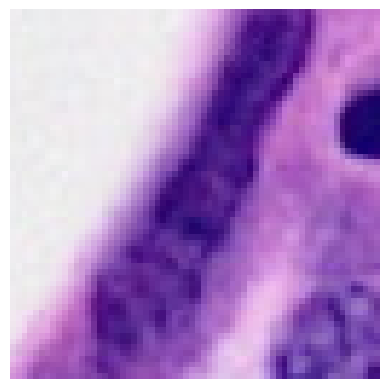

In [8]:
from tools.analysis import plot_cell
plot_cell(image_dict, cell_id=164463)

In [6]:
from tools.analysis import find_cell_max_cell_type

cell_type = "endothelial cell"
max_cell_id = find_cell_max_cell_type(cell_type, pred)
print(f"The cell ID with the highest proportion of '{cell_type}' is: {max_cell_id}")

The cell ID with the highest proportion of 'endothelial cell' is: 298163


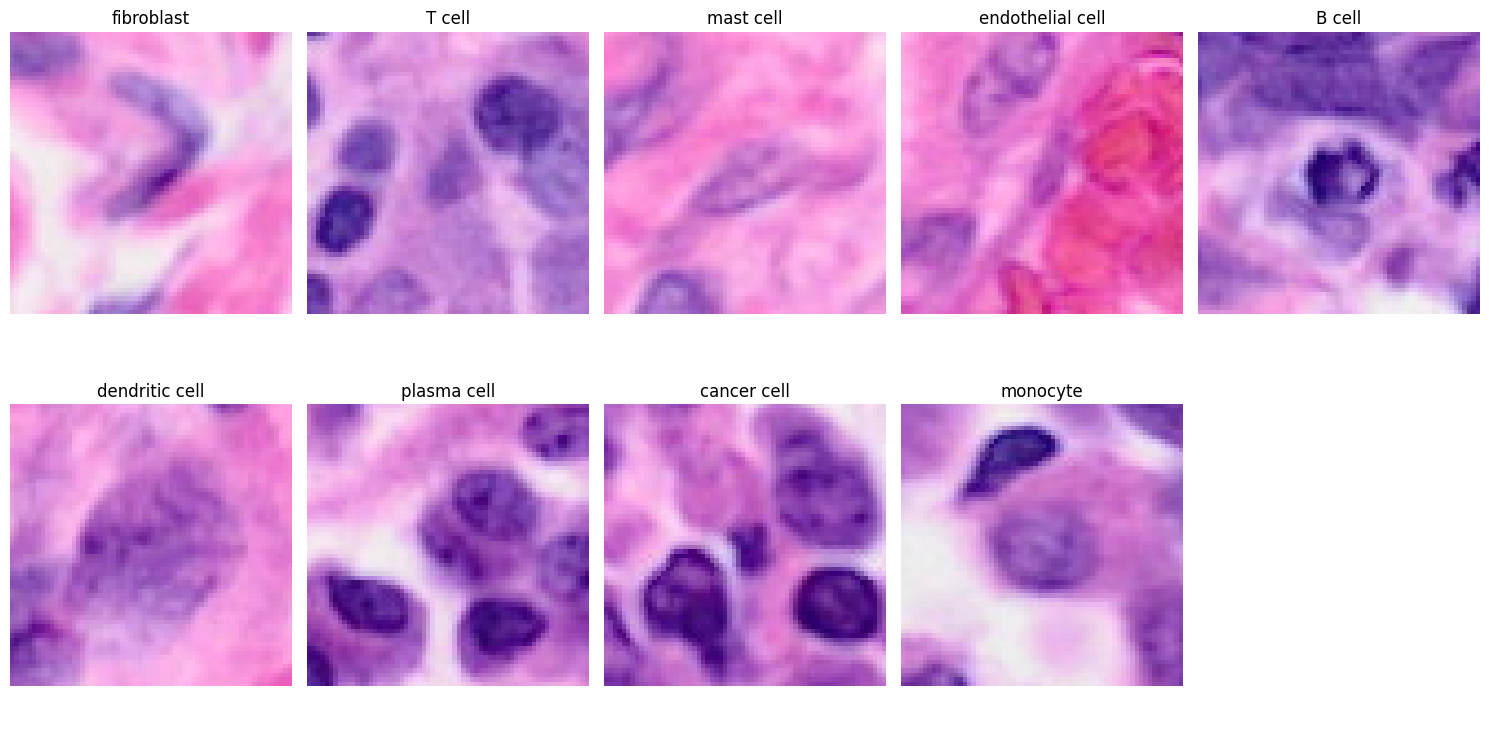

In [19]:
import matplotlib.pyplot as plt

n_cols = 5
n_rows = (len(ct_list) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows * 4))
axs = axs.flatten()

for i, cell_type in enumerate(ct_list):
    cell_id = find_cell_max_cell_type(cell_type, pred)
    ax = axs[i]
    plot_cell(image_dict, ax=ax, cell_id=cell_id)
    ax.set_title(cell_type, fontsize=12)

# Turn off axes for unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [38]:
from tools.analysis import generate_dicts_viz_pred
pred_dict, color_dict = generate_dicts_viz_pred(hovernet_dict, labels_dict, ct_list)

In [39]:
from tools.slide_viz import SlideVisualizer

window = ((25000, 4000), (2000, 2000)) #((25000, 4000), (2000, 2000))
plotter = SlideVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        dict_cells = pred_dict, 
                        dict_types_colors = color_dict, 
                        window = window)

Visium data found.


TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


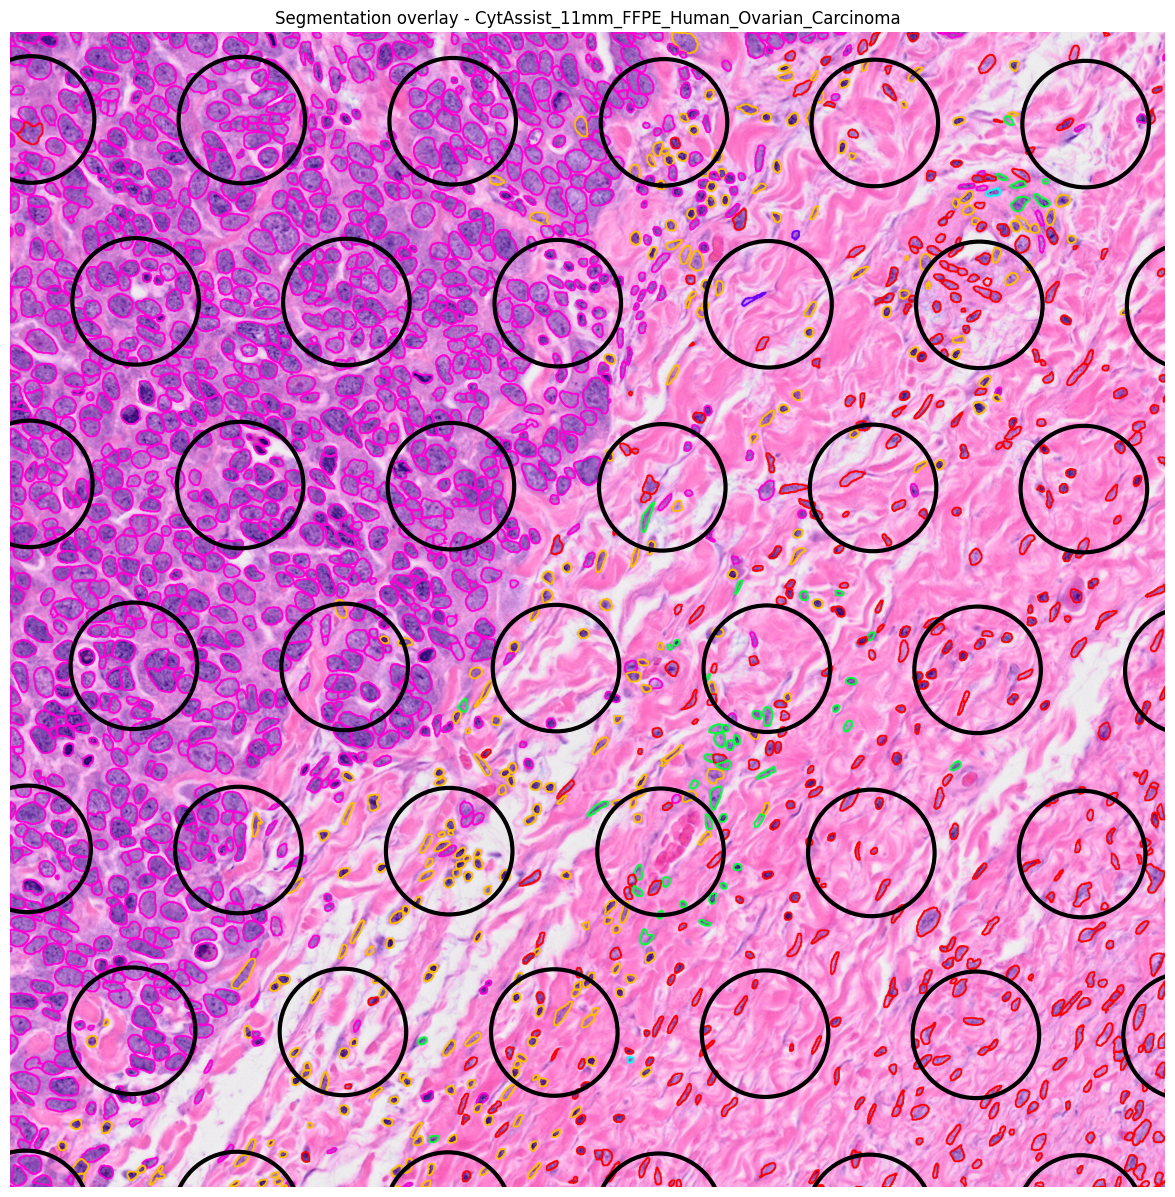

In [40]:
plotter.plot_seg(show_visium=True)

In [16]:
proportions.loc['TGGACGCATAAGCGCT-1']

fibroblast          0.095117
T cell              0.031019
mast cell           0.003532
endothelial cell    0.122091
B cell              0.000479
dendritic cell      0.000485
plasma cell         0.159725
cancer cell         0.529401
monocyte            0.058150
Name: TGGACGCATAAGCGCT-1, dtype: float64

Visium data found.


TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


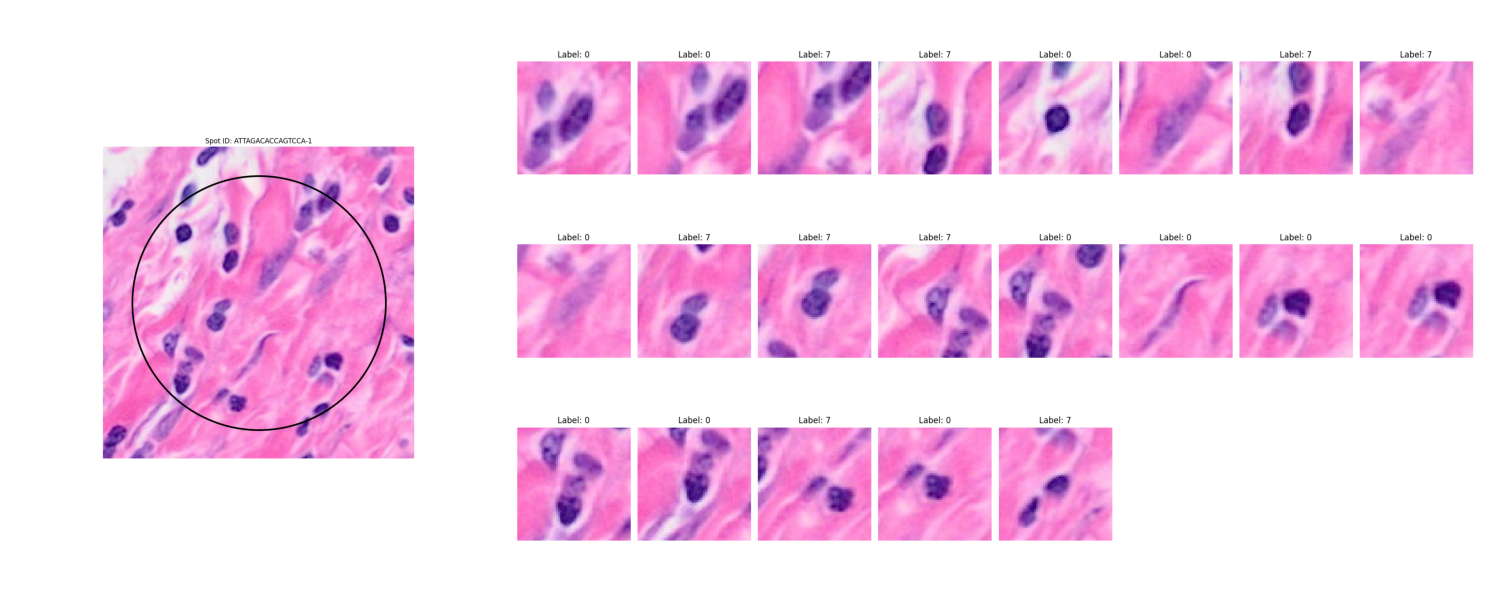

In [50]:
from tools.analysis import plot_predicted_cell_labels_in_spot
plot_predicted_cell_labels_in_spot(spot_dict,
                                   image_path, 
                                   adata, 
                                   adata_name, #json_path,
                                   image_dict,
                                   labels_pred=labels_dict,
                                   spot_id="ATTAGACACCAGTCCA-1",
                                   display=True)

Visium data found.


TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


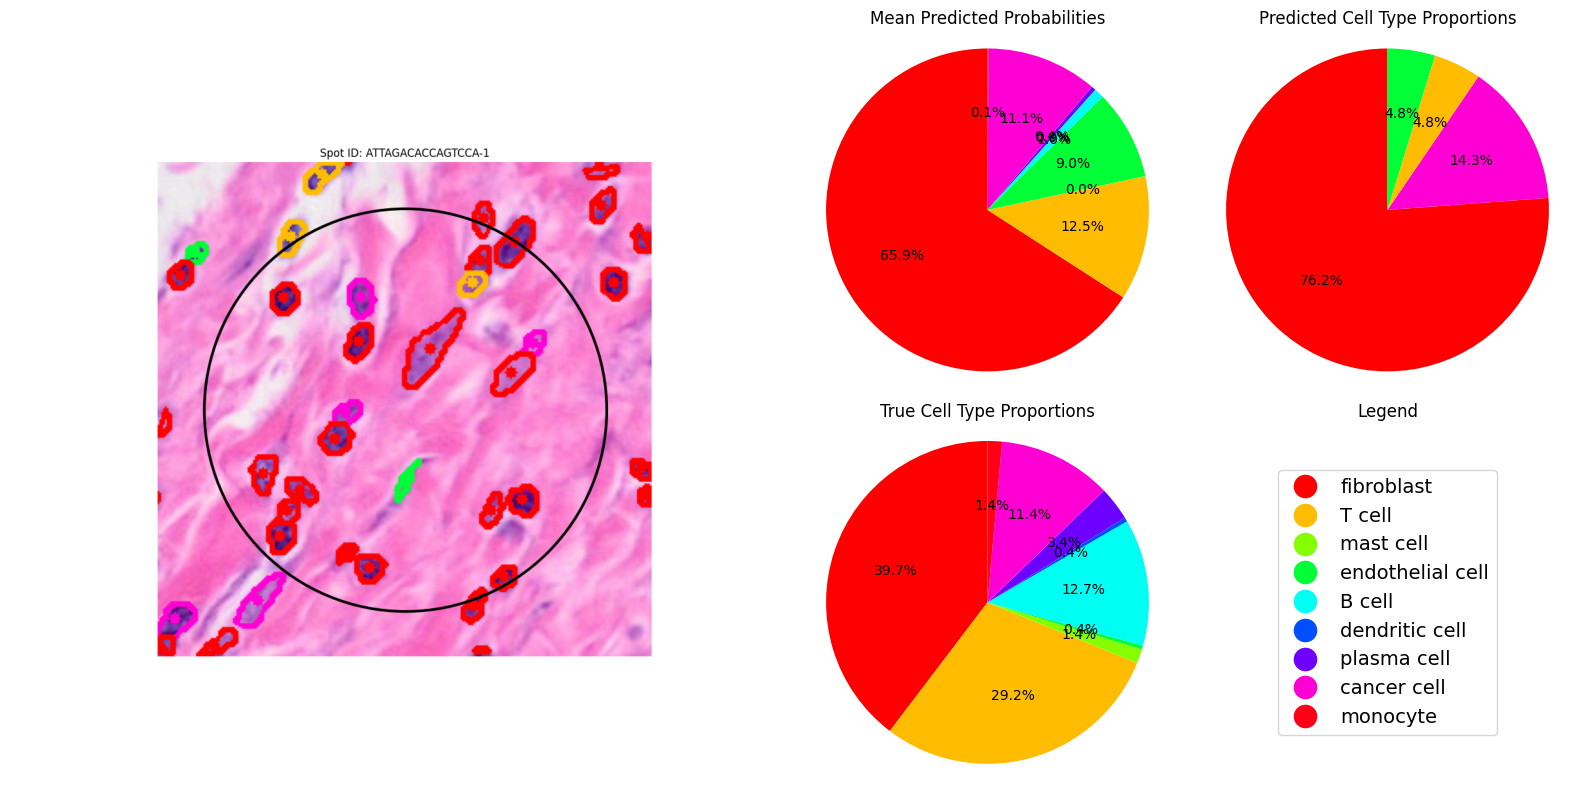

In [23]:
from tools.analysis import plot_spots_proportions

plot_spots_proportions(image_path, 
                       adata, 
                       adata_name, 
                       proportions, 
                       spot_dict, 
                       pred, 
                       dict_cells=pred_dict,
                       dict_types_colors=color_dict,
                       spot_id="ATTAGACACCAGTCCA-1")

- dans l’equation (2), on parle vraiment cellule par cellule. p(x) c’est la distribution d’une image dans le training set, etc… et p(c) c’est la proportion globale sur le training set.
- Or dans un spot précis, les proportions peuvent être très différentes de p(c) global du training set
- donc on ajuste les proportions (probas) trouvées pour chaque cellule (p(c|x)) en se disant que p(x|c) ne change pas.
- et donc on obtient l’equation (5), avec p(c|x) le vecteur de proba de la cellule i (correspondant à l’image x) trouvé avec le CNN; p(c) c’est les proportions globales sur le training set; p~(c) c’est les proportions de C2L du spot dans lequel se trouve la cellule i; alpha(x) correspond à la formule (7).

In [50]:
from tools.analysis import evaluate_performance
import pandas as pd

df = pd.read_csv("../out/summary_metrics_l2_final_adj.csv")
result = evaluate_performance(df, feature_a="alpha", feature_b=["lr", "weights"], metric="Spearman Correlation", divergence="l2")
result

lr         0.0001           0.0010          
weights     False     True   False     True 
alpha                                       
0.0000   0.875795  0.873831    NaN  0.598844
0.0001   0.868801  0.673550    NaN  0.427701
0.0010   0.831358  0.608844    NaN  0.633130

# Tests on loss

In [6]:
# from module.loss import weighted_l1_loss, weighted_l2_loss, weighted_kl_divergence

# def loss_comb(outputs, true_proportions, weights=None, agg="proba", divergence="l1", reduction="mean", alpha=0):
#     """
#     Computes the loss of the model.

#     Args:
#         outputs: The output of the model
#         true_proportions: The true proportions of the classes
#         weights: The weights of the classes. If None, the weights are set to 1.
#         agg: The aggregation method of the output. Can be "proba" or "onehot".
#         divergence: The divergence to use. Can be "l1", "l2" or "kl".
#         reduction: The reduction method of the loss. Can be "mean" or "sum".
#         alpha: The weight of the max probability loss. If not 0, we recommend a very low 
#                 value (~... for l1 and l2, ~... for kl). It also depends on 'weights'.
#     """

#     if weights is None:
#         weights = torch.ones_like(true_proportions)
#         # print("Weights : ", weights)

#     max_prob_loss = -torch.mean(torch.log(outputs.max(dim=1)[0]))
#     # print("Max prob loss : ", max_prob_loss)

#     if agg == "proba":
#         pred_proportions = outputs.mean(dim=0)
#     elif agg == "onehot":
#         predicted_classes = torch.argmax(outputs, dim=1)
#         one_hot_preds = torch.nn.functional.one_hot(predicted_classes, num_classes=outputs.size(1))
#         pred_proportions = one_hot_preds.float().sum(dim=0) / outputs.size(0)
#     else:
#         raise ValueError(f"Invalid aggregation method: {agg}. Use 'proba' or 'onehot'.")

#     # print("Pred proportions : ", pred_proportions)

#     if divergence == "l1":
#         divergence_loss = weighted_l1_loss(pred_proportions, true_proportions, weights, reduction=reduction)
#     elif divergence == "mse":
#         divergence_loss = weighted_l2_loss(pred_proportions, true_proportions, weights, reduction=reduction)
#     elif divergence == "kl":
#         divergence_loss = weighted_kl_divergence(pred_proportions, true_proportions, weights, reduction=reduction)
#     else:
#         raise ValueError(f"Invalid divergence type: {divergence}. Use 'l1', 'mse', or 'kl'.")
    
#     # print("Divergence loss : ", divergence_loss)

#     loss = alpha * max_prob_loss + (1 - alpha) * divergence_loss

#     return loss

In [7]:
# global_proportions = proportions.mean(axis=0).values
# weights = 1.0 / global_proportions
# weights /= weights.sum()
# weights = torch.tensor(weights)

In [40]:
# proportions["dendritic cell"].idxmax()

'GACCAGATAGCAGGCA-1'

In [187]:
# output_0 = torch.tensor([[0, 0, 0, 0, 0, 0.01, 0, 0.99, 0], 
#                          [0, 0, 0, 0, 0, 0.01, 0, 0.99, 0],
#                          [0, 0, 0, 0, 0, 0.01, 0, 0.99, 0],
#                          [0, 0, 0, 0, 0, 0.01, 0, 0.99, 0],
#                          [0, 0, 0, 0, 0, 0.01, 0, 0.99, 0],
#                          [0, 0, 0, 0, 0, 0.01, 0, 0.99, 0]])

# output_1 = torch.tensor([[0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0], 
#                          [0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0],
#                          [0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0],
#                          [0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0],
#                          [0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0],
#                          [0.1, 0.2, 0, 0, 0, 0.05, 0, 0.65, 0]])

# output_2 = torch.tensor([[0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0], 
#                          [0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0],
#                          [0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0],
#                          [0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0],
#                          [0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0],
#                          [0.2, 0.3, 0, 0, 0.05, 0.02, 0, 0.43, 0]])

# output_3 = torch.tensor([[0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0], 
#                          [0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0],
#                          [0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0],
#                          [0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0],
#                          [0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0],
#                          [0.35, 0.5728, 0, 0, 0.05, 0, 0, 0.0272, 0]])

# output_4 = torch.tensor([[0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0], 
#                          [0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0],
#                          [0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0],
#                          [0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0],
#                          [0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0],
#                          [0.2, 0.45, 0.005, 0.01, 0.1, 0.06, 0.05, 0.125, 0]])

# output_0 = torch.where(output_0 == 0, 0.00001, output_0)
# output_1 = torch.where(output_1 == 0, 0.00001, output_1)
# output_2 = torch.where(output_2 == 0, 0.00001, output_2)
# output_3 = torch.where(output_3 == 0, 0.00001, output_3)
# output_4 = torch.where(output_4 == 0, 0.00001, output_4)

In [10]:
# pred_proportions = output_0.mean(dim=0)
# pred_proportions

tensor([1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-02,
        1.0000e-05, 9.9000e-01, 1.0000e-05])

In [214]:
# true_proportions = torch.tensor(proportions.loc["GACCAGATAGCAGGCA-1"].values)
# true_proportions

tensor([0.2265, 0.4667, 0.0086, 0.0099, 0.1077, 0.0747, 0.0236, 0.0273, 0.0550],
       dtype=torch.float64)

In [97]:
# for w in [None, weights]:
#     for agg in ["proba", "onehot"]:
#         for div in ["l1", "mse", "kl"]:
#             for red in ["mean", "sum"]:
#                     print(w is not None, agg, div, red)
#                     for pred_vec in [output_0, output_1, output_2, output_3, output_4]:
#                         print(f"{float(loss_comb(pred_vec, true_proportions, weights=w, agg=agg, divergence=div, reduction=red)):.3f}")
#                         print(f"proba max: {float(-torch.mean(torch.log(pred_vec.max(dim=1)[0]))):.3f}")

In [13]:
# divergence_loss = weighted_kl_divergence(pred_proportions, true_proportions, weights)
# divergence_loss

tensor(0.0008, dtype=torch.float64)

In [211]:
# def weighted_kl_divergence(p, q, weights, reduction="sum"):
#     p = p.clamp(min=1e-10)
#     q = q.clamp(min=1e-10)

#     loss = p * torch.log(p / q) - p + q
#     w_loss = weights * loss

#     if reduction == "mean":
#         return w_loss.mean()
#     elif reduction == "sum":
#         return w_loss.sum()
#     else:
#         raise ValueError(f"Invalid reduction mode: {reduction}. Use 'mean' or 'sum'.")


# def shannon_entropy(U):
#     return -(U * torch.log(U + 1e-12)).sum()

# def ROT(F, z, alpha=0.5, epsilon=1, n_iter=75, weights=None, reduction="sum"):
#     """
#     Compute a differentiable approximation to f_relax-ent using Algorithm 1.

#     Args:
#         F (torch.Tensor): Tensor of shape (n, k) representing the predicted probability distributions.
#         z (torch.Tensor): Tensor of shape (k,) representing the target distribution.
#         alpha (float): Smoothing parameter in [0, 1].
#         epsilon (float): Entropy parameter, must be > 0.
#         n_iter (int): Number of Sinkhorn iterations.

#     Returns:
#         torch.Tensor: The differentiable approximation to f_relax-ent(F, z).
#     """
#     n, _ = F.shape
#     # Step 1: Initialize variables
#     K = F.pow(1 / epsilon)
#     K = K.t()

#     tau = (1 + alpha * epsilon / (1 - alpha)) ** -1

#     b = torch.ones(n, device=F.device)

#     # Steps 2-3: Perform Sinkhorn iterations
#     for _ in range(n_iter):
#         # Update a
#         a = ((n * z / (K @ b)).pow(tau))
#         print(a.dtype)
#         # Update b
#         b = (torch.ones(n, device=F.device) / (K.t() @ a))

#     # Step 6: Compute U
#     U = torch.diag(a) @ K @ torch.diag(b)

#     # Step 7: Compute the final approximation to f_relax-ent
#     trace_logF_U = torch.trace(torch.log(F) @ U)
#     entropy_U = shannon_entropy(U)
#     kld = weighted_kl_divergence(U @ torch.ones(n, device=F.device) / n, z, weights=weights, reduction=reduction)

#     # Compute the final differentiable approximation
#     return (alpha / n) * (-trace_logF_U - epsilon * entropy_U) + (1 - alpha) * kld

In [225]:
# true_proportions

In [224]:
# ROT(output_0, true_proportions, alpha=0.5, epsilon=1, n_iter=75, weights=torch.ones(9), reduction="sum")

# Tests on datasets

In [18]:
# from utils.hovernet_tools import map_cells_to_spots
# from data.load_data import split_data
# spot_dict = map_cells_to_spots(adata, adata_name, json_path)

In [19]:
# from data.load_data import SpotDataset, collate_fn

# train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
#         spot_dict, proportions, train_size=0.5, val_size=0.25)
    
# # Create datasets
# train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict)
# val_dataset = SpotDataset(val_spot_dict, val_proportions, image_dict)
# test_dataset = SpotDataset(test_spot_dict, test_proportions, image_dict)

In [20]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn) #added collate_fn
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn

In [21]:
# for batch in train_loader:
#     test_images = batch[0][0]
#     test_vector = batch[1][0]
#     break

In [22]:
# test_images.shape

In [23]:
# test_vector

In [24]:
# import numpy as np

# df = proportions.copy()
# df['distance'] = df.apply(lambda row: np.linalg.norm(row.values - test_vector.cpu().numpy()), axis=1)

# # Trouver l'index de la ligne la plus proche
# index_ligne_proche = df['distance'].idxmin()

In [25]:
# proportions.loc[index_ligne_proche]

In [26]:
# len(spot_dict[index_ligne_proche])

# For extracting some metrics

In [18]:
# import os
# import itertools
# from tools.analysis import evaluate_spot_predictions, get_predicted_proportions
# import pandas as pd

# def aggregate_metrics(metrics_list):
#     """Calculate the mean for each metric across multiple runs."""
#     mean_metrics = pd.DataFrame(metrics_list).mean().to_dict()
#     return mean_metrics

# output_dir = "../out/rot"
# alphas = [0.3]
# learning_rates = [1e-5]
# weights_options = [True, False]
# seeds = [42, 43, 44, 45, 46, 47]

# results_best = []
# results_best_adj = []
# results_final = []
# results_final_adj = []
# combinations = list(itertools.product(alphas, learning_rates, weights_options))

# for alpha, lr, weights in combinations:
#     metrics_best_list = []
#     metrics_best_adj_list = []
#     metrics_final_list = []
#     metrics_final_adj_list = []

#     for seed in range(42, 48):
#         info_path = os.path.join(
#             output_dir,
#             f"alpha_{alpha}_lr_{lr}_weights_{weights}_divergence_rot_seed_{seed}",
#             "info.pickle",
#         )
#         if os.path.exists(info_path):
#             print("Seed ", seed, " exists")
#             with open(info_path, "rb") as f:
#                 info = pickle.load(f)

#             spot_dict = info["spot_dict"]
#             true_proportions = info["proportions"]
#             pred_best = info["pred_best"]
#             pred_best_adj = info["pred_best_adjusted"]

#             is_final = True
#             try:
#                 pred_final = info["pred_final"]
#                 pred_final_adj = info["pred_final_adjusted"]
#             except Exception:
#                 is_final = False

#             # Load true and predicted proportions
#             predicted_best_proportions = get_predicted_proportions(pred_best, spot_dict)
#             predicted_best_proportions_adj = get_predicted_proportions(pred_best_adj, spot_dict)

#             if is_final:
#                 predicted_final_proportions = get_predicted_proportions(pred_final, spot_dict)
#                 predicted_final_proportions_adj = get_predicted_proportions(pred_final_adj, spot_dict)

#             # Evaluate the metrics
#             metrics_best = evaluate_spot_predictions(true_proportions, predicted_best_proportions)
#             metrics_best_adj = evaluate_spot_predictions(true_proportions, predicted_best_proportions_adj)

#             if is_final:
#                 metrics_final = evaluate_spot_predictions(true_proportions, predicted_final_proportions)
#                 metrics_final_adj = evaluate_spot_predictions(true_proportions, predicted_final_proportions_adj)

#             metrics_best_list.append(metrics_best)
#             metrics_best_adj_list.append(metrics_best_adj)

#             if is_final:
#                 metrics_final_list.append(metrics_final)
#                 metrics_final_adj_list.append(metrics_final_adj)

#     mean_metrics_best = aggregate_metrics(metrics_best_list)
#     mean_metrics_best_adj = aggregate_metrics(metrics_best_adj_list)
#     mean_metrics_final = aggregate_metrics(metrics_final_list)
#     mean_metrics_final_adj = aggregate_metrics(metrics_final_adj_list)

#     result_best = {"alpha": alpha, "lr": lr, "weights": weights, "divergence": "rot", **mean_metrics_best}
#     result_best_adj = {
#         "alpha": alpha,
#         "lr": lr,
#         "weights": weights,
#         "divergence": "rot",
#         **mean_metrics_best_adj,
#     }
#     result_final = {"alpha": alpha, "lr": lr, "weights": weights, "divergence": "rot", **mean_metrics_final}
#     result_final_adj = {
#         "alpha": alpha,
#         "lr": lr,
#         "weights": weights,
#         "divergence": "rot",
#         **mean_metrics_final_adj,
#     }

#     results_best.append(result_best)
#     results_best_adj.append(result_best_adj)
#     results_final.append(result_final)
#     results_final_adj.append(result_final_adj)

# # Save final results
# results_df_best = pd.DataFrame(results_best)
# results_df_best_adj = pd.DataFrame(results_best_adj)
# results_df_final = pd.DataFrame(results_final)
# results_df_final_adj = pd.DataFrame(results_final_adj)

# results_df_best.to_csv(os.path.join(output_dir, f"summary_metrics_rot_best.csv"), index=False)
# results_df_best_adj.to_csv(os.path.join(output_dir, f"summary_metrics_rot_best_adj.csv"), index=False)
# results_df_final.to_csv(os.path.join(output_dir, f"summary_metrics_rot_final.csv"), index=False)
# results_df_final_adj.to_csv(os.path.join(output_dir, f"summary_metrics_rot_final_adj.csv"), index=False)